In [2]:
%matplotlib widget
import pylab as plt
import numpy as np
from astropy.io import fits
from glob import iglob,glob
from sklearn.decomposition import PCA

In [3]:
from sklearn.linear_model import HuberRegressor
from sklearn.preprocessing import StandardScaler

def Huber_continuum(x,y):
 
    # standardize    
    x_scaler, y_scaler = StandardScaler(), StandardScaler()
    x_train = x_scaler.fit_transform(x[..., None])
    y_train = y_scaler.fit_transform(y[..., None])

    # fit model
    model = HuberRegressor(epsilon=1)
    model.fit(x_train, y_train.ravel())

    # do some predictions
    test_x = x
    predictions = y_scaler.inverse_transform(
        model.predict(x_scaler.transform(test_x[..., None]))
        )
    return(predictions)

In [4]:
idir = '/Users/cabrera-ziri/Work/data/eso/reticulum/Results/sky_res/'

# read all sky spectra
files = glob(idir+'*sky.fits')

for i,file in enumerate(files):	
	hdu = fits.open(file)

	# I would have tried to use the pipeline error spectra but the are very 
	# funky (values close to 0 and also many negatives). For the rest of 
	# the tests I'm using the sqrt of the flux as the uncertainty
	# hdu_e = fits.open(file.replace('sky.','err.'))

	# wavelenght0
	ext=0 
	crval = hdu[ext].header['crval1']
	cdelt = hdu[ext].header['cdelt1']
	naxis = hdu[ext].header['naxis1']
	
	wl = crval+cdelt*np.arange(naxis)
	flux = hdu[ext].data
	flux = flux/Huber_continuum(wl,flux)
	
	# err = hdu_e[ext].data
	err = np.sqrt(flux)

	#normalise error spectrum
	err_continuum = Huber_continuum(wl,err)

	if np.sum(err==0):
		#if there are 0 in error array replace with continuum
		#this avoids NaNs later down the road
		err[err==0] = err_continuum[err==0]

	if i == 0:
		#create array in first iteration 
		flux_array = np.empty(shape=(len(files),len(wl)))

	# fill array with flux of sky spectra normalised by its errors
	flux_array[i,:] = flux/(err/err_continuum)
	


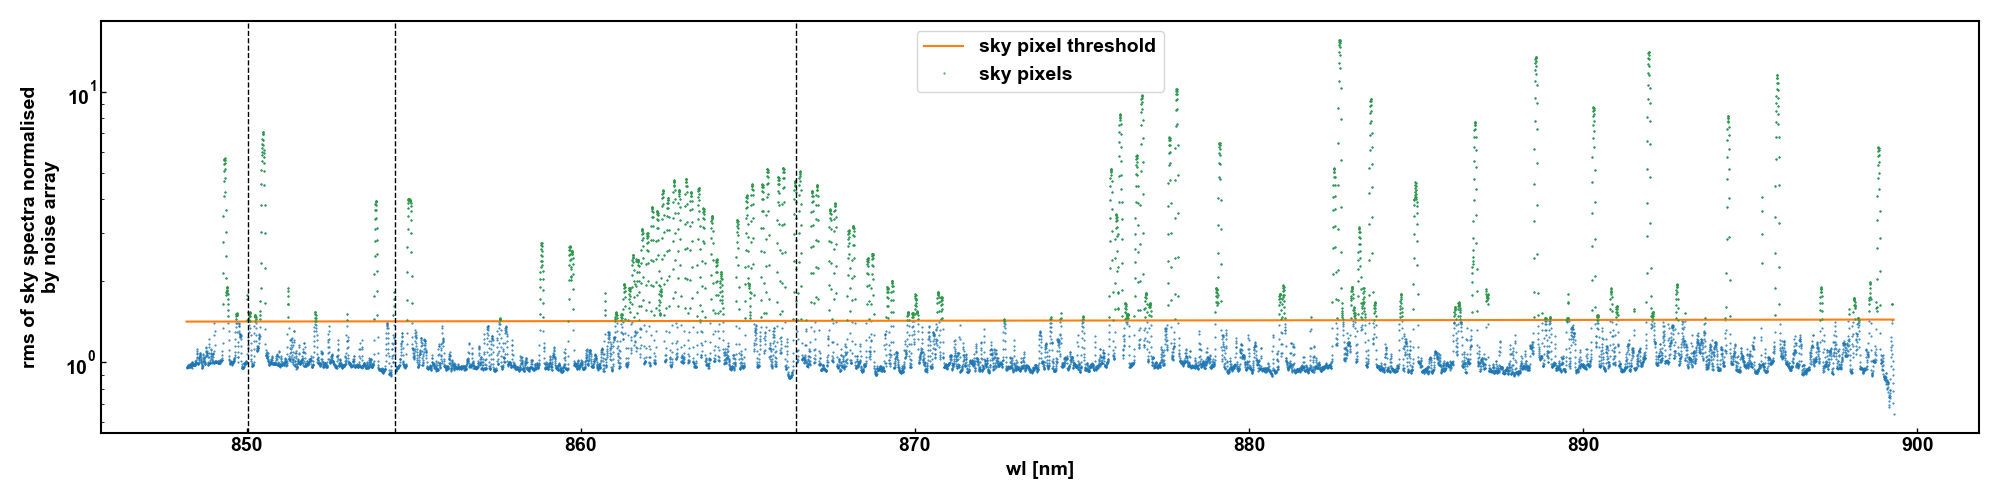

In [5]:
# calculate rms of sky spectra normalised by noise array	
rms = np.sqrt(np.nanmean(flux_array**2,axis=0))

# we define the sky pixels as the pixes above
# the threshold given by sky_pixles
rms_continuum = Huber_continuum(wl,rms)

sky_pixel_scale_factor = 1.4 #this value was chosen by eye
sky_pixels = rms>=rms_continuum*sky_pixel_scale_factor

f, ax = plt.subplots(figsize=(20,5))  
ax.plot(wl,rms,'.',ms=1)
ax.plot(wl,rms_continuum*sky_pixel_scale_factor,label='sky pixel threshold')
ax.plot(wl[sky_pixels],rms[sky_pixels],'.',ms=1,label='sky pixels')
ax.set_xlabel('wl [nm]')
ax.set_ylabel('rms of sky spectra normalised\nby noise array')
plt.semilogy()
plt.legend()
for _ in [850.04,854.44, 866.45]:
    ax.axvline(_,lw=1,ls='--',color='k')
plt.tight_layout()

PCA(n_components=16)

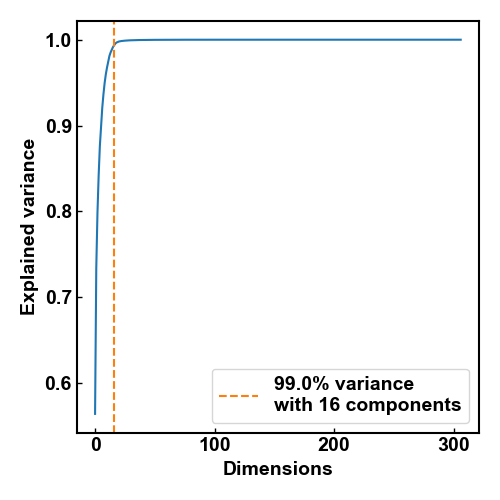

In [6]:
# 1st pca run 
pca = PCA()
pca.fit(flux_array[:,sky_pixels])
cumsum = np.cumsum(pca.explained_variance_ratio_)
explained_variance = 0.99
d = np.argmax(cumsum>=explained_variance)+1

f, ax = plt.subplots(figsize=(5,5))  
ax.plot(cumsum)
ax.axvline(d,ls='--',color='tab:orange',label='{:}% variance\nwith {:} components'.format(explained_variance*100,d))
ax.set_xlabel('Dimensions')
ax.set_ylabel('Explained variance')
plt.legend()
plt.tight_layout()

#re train
pca = PCA(n_components=d)
pca.fit(flux_array[:,sky_pixels])

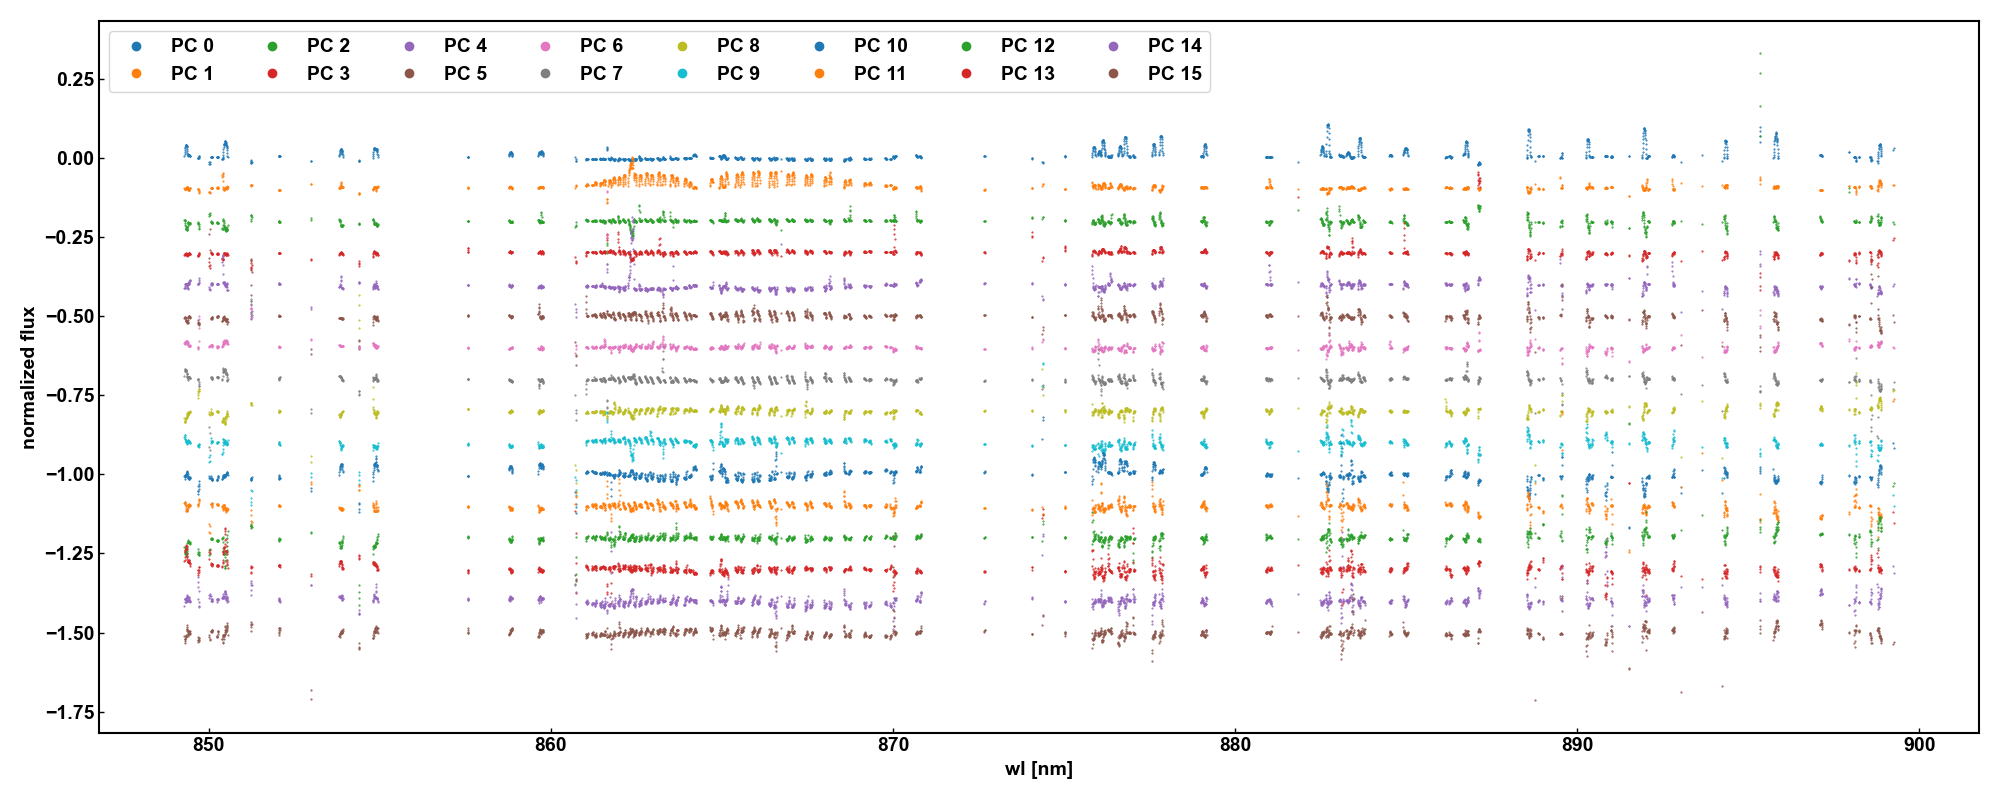

In [7]:
#plot first d-components
f, ax = plt.subplots(figsize=(20,8))

for _ in range(d):
    ax.plot(wl[sky_pixels],pca.components_[_]-(_*0.1),'.',ms=1,label='PC {:}'.format(_))
    ax.set_xlabel('wl [nm]')
    ax.set_ylabel('normalized flux')
    # plt.semilogy()
plt.legend(markerscale=12,ncol=int(np.ceil(d/2)))
plt.tight_layout()

In [8]:
spec_path = '/Users/cabrera-ziri/Work/data/eso/reticulum/Results/Results/Config1/Epoch01/690286592_c1_e01_hor5_nosky.fits'

hdu = fits.open(spec_path)

ext=0 
crval = hdu[ext].header['crval1']
cdelt = hdu[ext].header['cdelt1']
naxis = hdu[ext].header['naxis1']

wl = crval+cdelt*np.arange(naxis)
flux = hdu[ext].data

flux = flux/Huber_continuum(wl,flux)
plt.close('all')

In [9]:
weights = pca.transform(flux[sky_pixels][None,...])
model = pca.inverse_transform(weights)

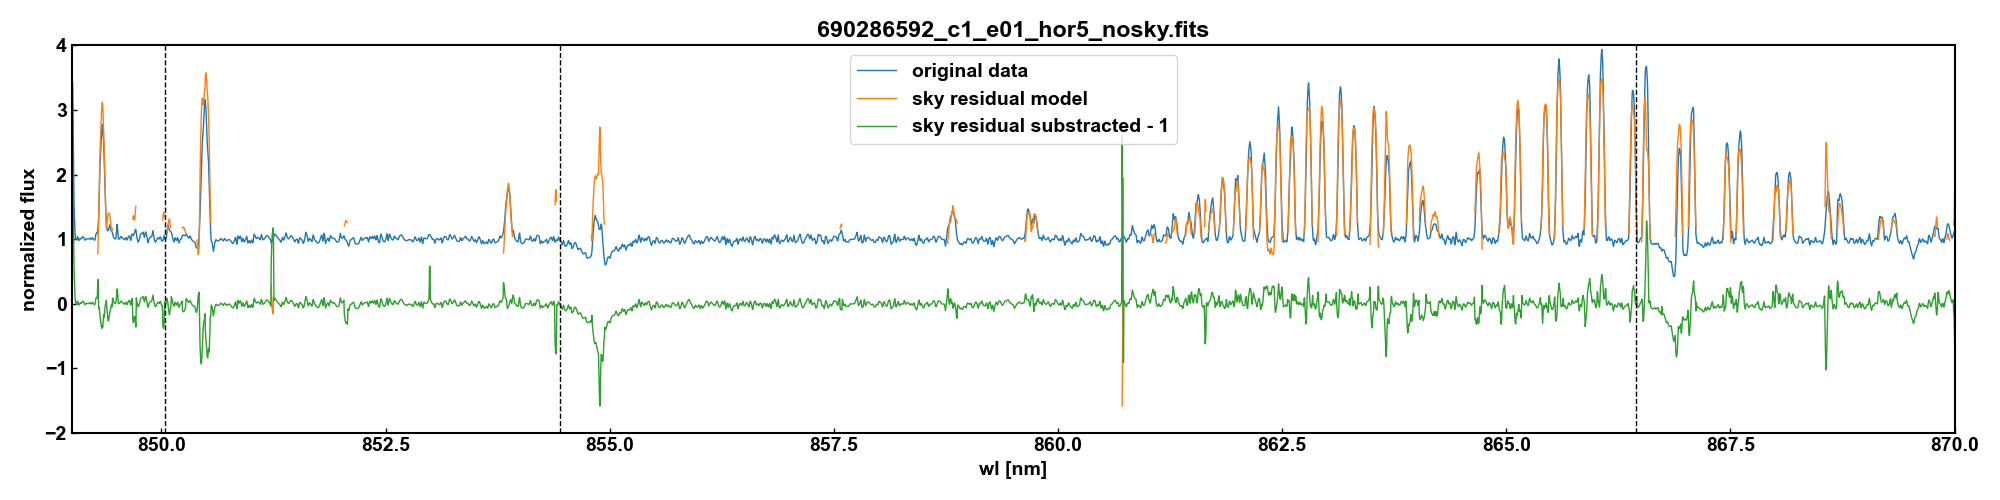

In [10]:
f, ax = plt.subplots(figsize=(20,5))
plt.title('690286592_c1_e01_hor5_nosky.fits')
ax.plot(wl,flux,'-',lw=1,label='original data')
_model = np.ones_like(wl)*np.nan
_model[sky_pixels] = model[0,:]
# ax.plot(wl[sky_pixels],model[0,:],'-',lw=1,label='sky residual model')
ax.plot(wl,_model,'-',lw=1,label='sky residual model')
flux2 = flux.copy()
flux2[sky_pixels] = flux2[sky_pixels]-model[0,:]+1
ax.plot(wl,flux2-1,ls='-',lw=1,label='sky residual substracted - 1')
for _ in [850.04,854.44, 866.45]:
    ax.axvline(_,lw=1,ls='--',color='k')
plt.legend(markerscale=12)
ax.set_xlim(849,870)
ax.set_ylim(-2,4)
ax.set_xlabel('wl [nm]')
ax.set_ylabel('normalized flux')
plt.tight_layout()